## Train Neural Network

In [1]:
import os
import tensorflow as tf
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets

In [2]:
# get all images and display the names 
input_img_paths=[]
target_img_paths=[]
input_dir = "Job_Images"
target_dir = "Reference_Images"
img_size = (750, 750)
num_classes = 2
batch_size = 10

input_img = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

target_img = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
input_img_paths=input_img_paths+input_img
target_img_paths=target_img_paths+target_img

print("Number of samples input:", len(input_img_paths))
print("Number of samples target:", len(target_img_paths))
try:
    input_img.remove('.ipynb_checkpoints')
except:
    pass
try:
    target_img.remove('.ipynb_checkpoints')
except:
    pass
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples input: 132
Number of samples target: 132
Job_Images\SI377320210706074338_012000.png | Reference_Images\SI377320210706074338_012000.png
Job_Images\SI377320210706074338_012030.png | Reference_Images\SI377320210706074338_012030.png
Job_Images\SI377320210706074338_012060.png | Reference_Images\SI377320210706074338_012060.png
Job_Images\SI377320210706074338_012090.png | Reference_Images\SI377320210706074338_012090.png
Job_Images\SI377320210706074338_012120.png | Reference_Images\SI377320210706074338_012120.png
Job_Images\SI377320210706074338_012150.png | Reference_Images\SI377320210706074338_012150.png
Job_Images\SI377320210706074338_012180.png | Reference_Images\SI377320210706074338_012180.png
Job_Images\SI377320210706074338_012210.png | Reference_Images\SI377320210706074338_012210.png
Job_Images\SI377320210706074338_012240.png | Reference_Images\SI377320210706074338_012240.png
Job_Images\SI377320210706074338_012270.png | Reference_Images\SI377320210706074338_012270.png


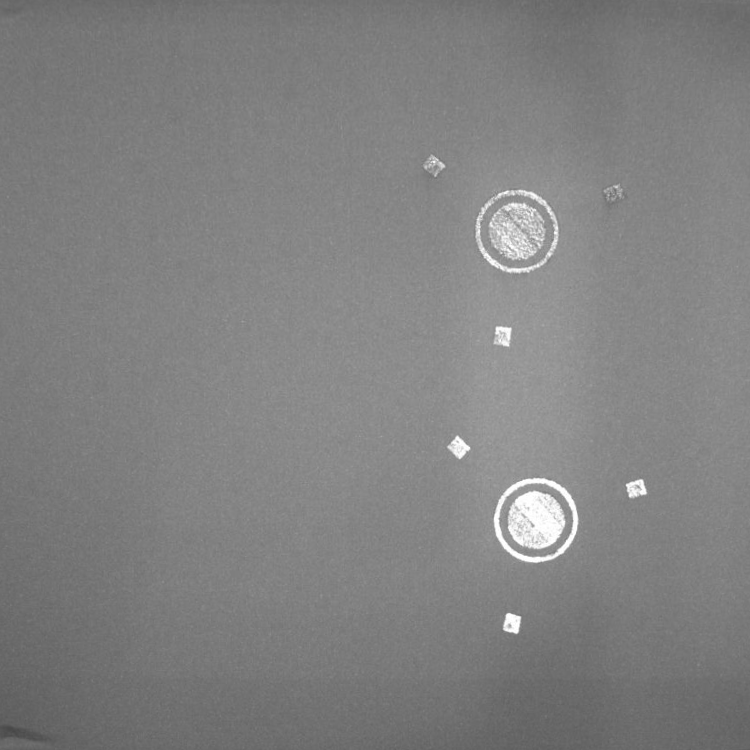

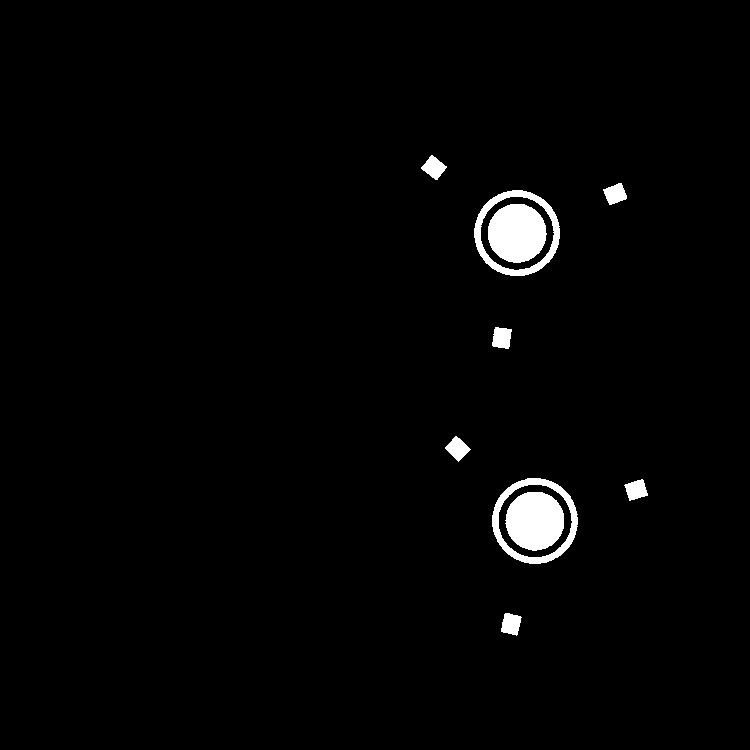

In [3]:
# Display input image 
img_sample = -1
display(Image(filename=input_img_paths[img_sample]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[img_sample], target_size=img_size))
display(img)


## Prepare `Sequence` class to load & vectorize batches of data

In [10]:
# class, that generates sequence for training and test, changes labels to 0 & 1
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            x[j] = np.expand_dims(img, 2)
            #x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 0, 255. Divide by 255 to get 0, 1:
            y[j] = y[j]/255
        return x, y

In [11]:


def get_model(img_size, num_classes):

    img_size = (750, 750)
    num_classes = 2
    batch_size = 10

    inputs = keras.Input(shape=img_size + (1,))
    x = layers.ZeroPadding2D(padding=1)(inputs)
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    x=layers.Cropping2D(cropping=1)(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model

    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 750, 750, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 752, 752, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 376, 376, 32  320         ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [12]:
train_input_img_paths, val_input_img_paths,train_target_img_paths, val_target_img_paths = train_test_split(input_img_paths, target_img_paths, train_size=0.8, random_state=42)
print(len(train_input_img_paths))
print(len(val_input_img_paths))

105
27


In [13]:
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
print(len(train_gen))

10


## Train the model

In [14]:
# Mean IOU Metric
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [9]:
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy',metrics=['accuracy',UpdatedMeanIoU(num_classes=2) ])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="models/PowderBed_model",save_weights_only=True,monitor='val_updated_mean_io_u',mode='max',save_best_only=True),
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
10/10 [==============================] - 298s 30s/step - loss: 1.5435 - accuracy: 0.9051 - updated_mean_io_u: 0.4868 - val_loss: 330.0920 - val_accuracy: 1.7778e-06 - val_updated_mean_io_u: 0.0067
Epoch 2/10
10/10 [==============================] - 280s 26s/step - loss: 0.1541 - accuracy: 0.9860 - updated_mean_io_u: 0.6708 - val_loss: 64.6469 - val_accuracy: 1.6889e-05 - val_updated_mean_io_u: 0.0067
Epoch 3/10
10/10 [==============================] - 262s 26s/step - loss: 0.1047 - accuracy: 0.9825 - updated_mean_io_u: 0.6824 - val_loss: 45.4190 - val_accuracy: 8.4196e-04 - val_updated_mean_io_u: 0.0071
Epoch 4/10
10/10 [==============================] - 243s 25s/step - loss: 0.1391 - accuracy: 0.9861 - updated_mean_io_u: 0.6606 - val_loss: 0.0650 - val_accuracy: 0.9924 - val_updated_mean_io_u: 0.5676
Epoch 5/10
10/10 [==============================] - 243s 24s/step - loss: 0.0340 - accuracy: 0.9851 - updated_mean_io_u: 0.7363 - val_loss: 0.0561 - val_accuracy: 0.9954 - val_

### Save model

In [10]:
model.save('models/PowderBed_model')

INFO:tensorflow:Assets written to: models/PowderBed_model\assets


INFO:tensorflow:Assets written to: models/PowderBed_model\assets
